##  고급 회기 실습 : 캐글 주택 가격 회기 분석

### 사용 데이터 
데이터 다운로드  
https:www.kaggle.com  
house 검색  
train.csv 파일 다운로드 받아서  
house_price.csv로 저장

---
house_price 데이터
- 79개의 변수로 구성
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

### 전체 회귀 분석 과정
1. 데이터 전처리 : Null, target 값 로그 변환, 원-핫 인코딩  
2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  
   (1) 학습/예측/평가   
   (2) 모델별 회귀 계수 시각화  
   (3) 교차 검증 수  
   (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가  
3. 피처 데이터 변환  
   (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩  
   (2) 모델 학습/예측/평가   
   (3) 모델별 회귀 계수 시각화  
   (4) 이상치 처리  
   (5) 릿지 / 라쏘 모델 최적화 수행  
4. 회귀 트리 모델  : XGBoost와 LightGBM   
   (1) 학습/예측/평가   
   (2) 피처 중요도 시각화  
5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
   -  릿지 모델(40%)과 라쏘 모델(60%) 혼합  
6. 스태킹 앙상블 모델을 통한 회귀 예측  
   - 스태킹 앙상블 모델  

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

### 1.  데이터 전처리
- Null 값 처리, target 값 로그 변환, 원-핫 인코딩   

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('../data/house_price.csv')
# 가공 작업 중에 원본 데이터 필요
# 원본 데이터 유지하기 위해, 복사본으로 가공 작업 진행 
house_df = house_df_org.copy()
house_df.head()
house_df.tail()

# Target 값 : SalePrice (주택 가격) (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


주요 피처들

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet      
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet      
- GarageArea: Size of garage in square feet      
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	  
- OverallCond: Rates the overall condition of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average	  
       5	Average  
       4	Below Average	  
       3	Fair  
       2	Poor  
       1	Very Poor  
- YearBuilt: Original construction date  
- Neighborhood: Physical locations within Ames city limits  
   Blmngtn  Bloomington Heights  
   Blueste  Bluestem  
   BrDale   Briardale  
   .....

- RoofMatl: Roof material  
	ClyTile	Clay or Tile  
	CompShg	Standard (Composite) Shingle  
	Membran	Membrane  
	Metal	Metal  
	.....

- RoofStyle: Type of roof  
	Flat	Flat  
	Gable	Gable  
	Gambrel	Gabrel (Barn)  
	.....

#### 데이터 확인

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#  데이터 타입 확인


In [5]:
# Null 값 개수 및 피처 확인 
null_count = house_df.isnull().sum()
null_count[null_count>0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

데이터 확인 결과
- 1460개의 레코드(행, 건), 81개의 피처로 구성
- 피처 타입 : 문자형(object), 숫자형(정수(int), 실수(float))
- Target을 제외한 80개의 피처 중 43개 문자형, 나머지 숫자형
- 데이터 양에 비해 Null 값이 많은 피처 존재
- 1,000개가 넘는 데이터가 Null 인 피처도 존재
- Null이 너무 많은 피처는 drop할 것임

### 회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인

<Axes: xlabel='SalePrice', ylabel='Count'>

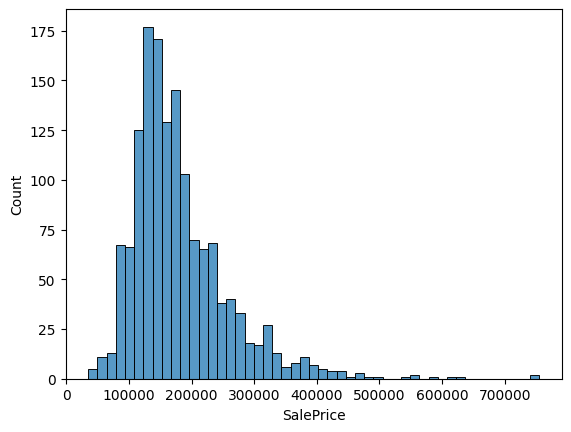

In [6]:
# 타깃값 SalePrice의 분포도 확인
sns.histplot(house_df['SalePrice'])
plt.show()


### 로그 변환 및 환원
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환  
- 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법이 로그 변환    
- log1p() 이용해 로그 변환한 결과값을 기반으로 학습한 후  
- 예측 시 다시 결과값을 expm1()으로 환원해서 사용  
 

<Axes: xlabel='SalePrice', ylabel='Count'>

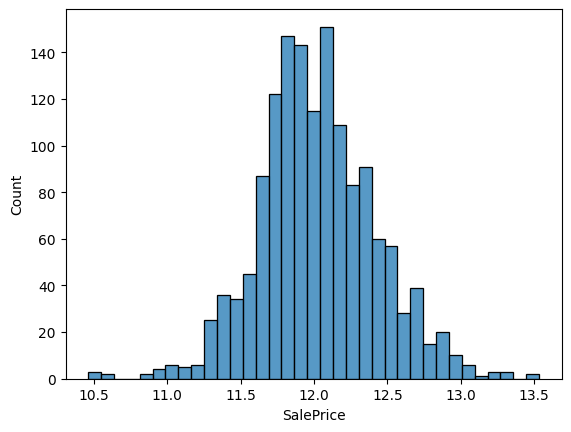

In [7]:
# target값을 로그 변환 후 SalePrice 값 분포도 확인
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
sns.histplot(house_df['SalePrice'])
plt.show()

### 데이터 확인 후 : 로그 변환 및 Null 처리
- 숫자형 피처에 대해 
    - Null이 너무 많은 피처는 삭제  
    - 기타 숫자형 Null값은 평균값으로 대체  

In [8]:
# SalePrice 로그 변환

In [9]:
# Null 이 너무 많은 피처와 불필요한 피처 삭제 
# ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']
need_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']
house_df.drop(need_to_drop, axis=1, inplace=True)
house_df.shape # column이 7개 줄어듦

(1460, 74)

In [10]:
# 삭제하지 않은 숫자형 Null 피처들은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)
# mean() : 자동으로 숫자형 칼럼만 추출해서 칼럼별 평균값을 시리즈 객체로 반환
# 버전 변경 후 자동으로 안 됨 : numeric_only 설정 필요

In [11]:
# Null 처리 후 확인 : Null 값이 있는 피처명과 타입 추출
null_count = house_df.isnull().sum()
col_with_null = null_count[null_count>0].index
house_df[col_with_null].dtypes

BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

### 카테고리 값의 문자열 변환
- ML 알고리즘에서 문자열 값을 입력 값으로 허용하지 않음
- 인코딩 처리하여 숫자형으로 변환


### 머신러닝의 대표적인 인코딩 방식
- 레이블 인코딩 (Label Encoding)
- 원-핫 인코딩 (One-Hot-Encoding)


In [12]:
# 원-핫 인코딩 수행 
house_df_ohe = pd.get_dummies(house_df, dtype=int)
house_df_ohe.shape

(1460, 267)

In [13]:
# Null 값을 가진 피처 확인
null_count = house_df_ohe.isnull().sum()
col_with_null = null_count[null_count>0].index
house_df_ohe[col_with_null].dtypes
# 더 이상 없다

Series([], dtype: object)

### 전처리 작업 완료 
- 종속 변수는 로그 변환
- 결측값 1000 건 이상 피처는 삭제
- 나머지 숫자형 피처의 결측값은 평균값으로 대체
- 문자형 피처는 원-핫 인코딩 진행 

### 2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  

### (1) 학습/예측/평가

In [14]:
X_feature = house_df_ohe.drop('SalePrice', axis=1)
y_target = house_df_ohe['SalePrice']

In [15]:
from sklearn.model_selection import train_test_split

def data_sep(X_feature, y_target):
    return [X_feature, y_target] + train_test_split(X_feature, y_target, test_size=0.3, random_state=156)

datas = data_sep(X_feature, y_target)

### 모델 생성/학습/예측/평가 

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from evaluator import get_eval

def models_eval(datas):
    *_, X_train , X_test , y_train , y_test = datas
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    lasso = Lasso()
    lasso.fit(X_train, y_train)

    print('<Linear Regression>')
    get_eval(lr_reg, X_test, y_test)
    print('---------------------')
    print('<Ridge>')
    get_eval(ridge, X_test, y_test)
    print('---------------------')
    print('<Lasso>')
    get_eval(lasso, X_test, y_test)

models_eval(datas)

<Linear Regression>
MSE : 0.016658
RMSE : 0.129064
R2 : 0.894153
---------------------
<Ridge>
MSE : 0.015482
RMSE : 0.124425
R2 : 0.901625
---------------------
<Lasso>
MSE : 0.029454
RMSE : 0.171621
R2 : 0.812842


### (2) 모델별 회귀 계수 시각화

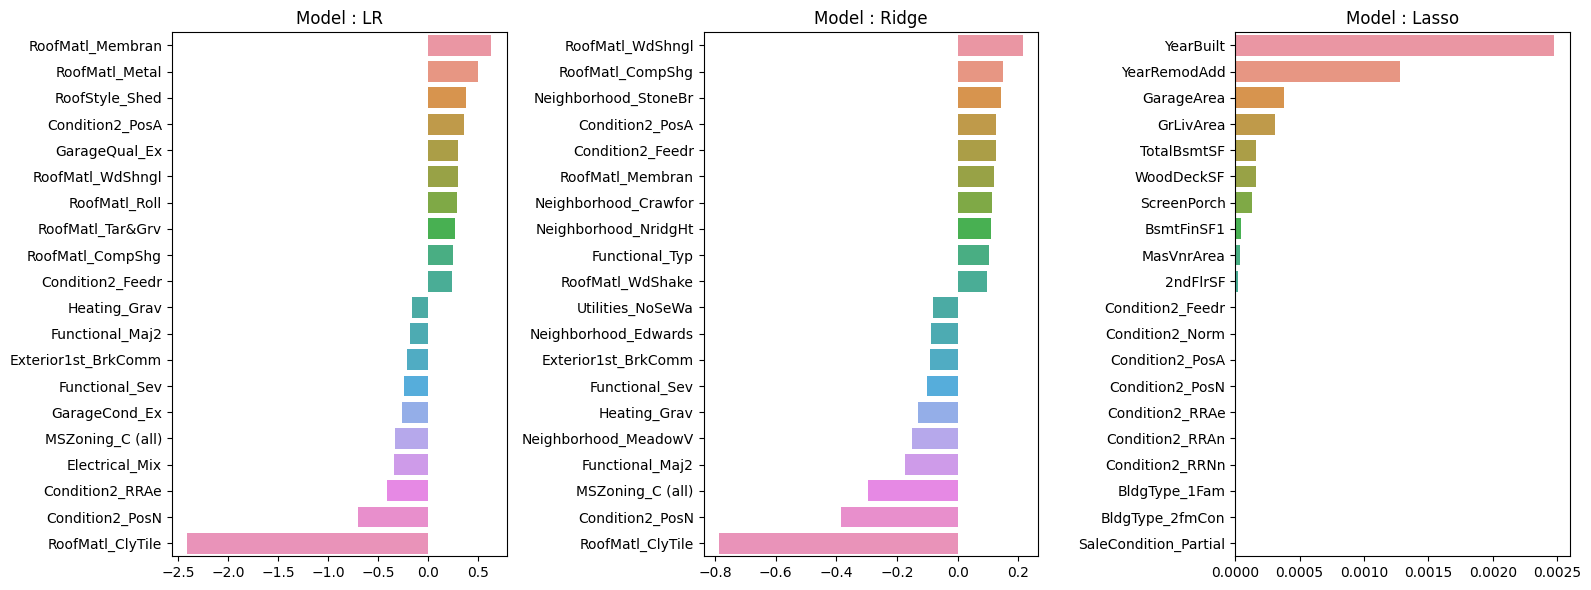

In [17]:
def models_visualize(datas):
    X_feature, y_target, *_ = datas
    models = [LinearRegression(), Ridge(), Lasso()]
    model_names = ['LR', 'Ridge', 'Lasso']

    fig, axs = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)

    for pos, model in enumerate(models):
        model.fit(X_feature, y_target)
        coef = pd.Series(data=model.coef_, index=X_feature.columns)
        colname = 'Model : ' + model_names[pos]
        coef_h = coef.sort_values(ascending=False).head(10)
        coef_t = coef.sort_values(ascending=False).tail(10)
        coef = pd.concat([coef_h, coef_t])
        axs[pos].set_title(colname)
        sns.barplot(x=coef.values, y=coef.index, ax=axs[pos])
    plt.tight_layout()
    plt.show()

models_visualize(datas)

### (3) 교차 검증 수행

In [18]:
from sklearn.model_selection import cross_val_score

def models_cross_val(datas):
    X_feature, y_target, *_ = datas
    models = [LinearRegression(), Ridge(), Lasso()]
    model_names = ['LR', 'Ridge', 'Lasso']
    for idx, model in enumerate(models):
        neg_mse = cross_val_score(model, X_feature, y_target, scoring='neg_mean_squared_error', cv=5)
        mse = -1*neg_mse
        print('Model : ', model_names[idx])
        print('MSE : ', mse.round(4))
        print('RMSE : ', np.sqrt(mse).round(4))
        print('Average of RMSE : ', np.mean(np.sqrt(mse)).round(4))
        print('----------------------------------')

models_cross_val(datas)

Model :  LR
MSE :  [0.0182 0.027  0.0277 0.0123 0.039 ]
RMSE :  [0.1349 0.1643 0.1664 0.1108 0.1976]
Average of RMSE :  0.1548
----------------------------------
Model :  Ridge
MSE :  [0.0138 0.0238 0.0201 0.0135 0.0356]
RMSE :  [0.1173 0.1541 0.1418 0.1164 0.1886]
Average of RMSE :  0.1437
----------------------------------
Model :  Lasso
MSE :  [0.0258 0.0418 0.0312 0.0329 0.0703]
RMSE :  [0.1608 0.2044 0.1768 0.1813 0.2651]
Average of RMSE :  0.1977
----------------------------------


### (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가 

In [19]:
ridge_params = [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]
lasso_params = [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]

def param_tuning(lin_reg, datas, params):
    *_, X_train, X_test, y_train, y_test = datas
    for alpha in params:
        print("\n * Alpha : ", alpha)
        model = lin_reg(alpha=alpha)
        model.fit(X_train, y_train)
        get_eval(model, X_test, y_test)
        print('-----------------------')

In [20]:
param_tuning(Ridge, datas, ridge_params)


 * Alpha :  0.05
MSE : 0.016198
RMSE : 0.127270
R2 : 0.897075
-----------------------

 * Alpha :  0.1
MSE : 0.015952
RMSE : 0.126302
R2 : 0.898635
-----------------------

 * Alpha :  1
MSE : 0.015482
RMSE : 0.124425
R2 : 0.901625
-----------------------

 * Alpha :  5
MSE : 0.015074
RMSE : 0.122778
R2 : 0.904213
-----------------------

 * Alpha :  8
MSE : 0.014891
RMSE : 0.122029
R2 : 0.905377
-----------------------

 * Alpha :  10
MSE : 0.014814
RMSE : 0.121713
R2 : 0.905867
-----------------------

 * Alpha :  12
MSE : 0.014760
RMSE : 0.121493
R2 : 0.906207
-----------------------

 * Alpha :  15
MSE : 0.014710
RMSE : 0.121285
R2 : 0.906528
-----------------------

 * Alpha :  20
MSE : 0.014676
RMSE : 0.121144
R2 : 0.906745
-----------------------


In [21]:
param_tuning(Lasso, datas, lasso_params)


 * Alpha :  0.001
MSE : 0.013631
RMSE : 0.116752
R2 : 0.913384
-----------------------

 * Alpha :  0.005
MSE : 0.018926
RMSE : 0.137572
R2 : 0.879738
-----------------------

 * Alpha :  0.008
MSE : 0.020045
RMSE : 0.141579
R2 : 0.872631
-----------------------

 * Alpha :  0.05
MSE : 0.024376
RMSE : 0.156127
R2 : 0.845110
-----------------------

 * Alpha :  0.03
MSE : 0.021744
RMSE : 0.147459
R2 : 0.861831
-----------------------

 * Alpha :  0.1
MSE : 0.028224
RMSE : 0.167999
R2 : 0.820659
-----------------------

 * Alpha :  0.5
MSE : 0.027816
RMSE : 0.166783
R2 : 0.823245
-----------------------

 * Alpha :  1
MSE : 0.029454
RMSE : 0.171621
R2 : 0.812842
-----------------------

 * Alpha :  5
MSE : 0.043449
RMSE : 0.208443
R2 : 0.723914
-----------------------

 * Alpha :  10
MSE : 0.046578
RMSE : 0.215819
R2 : 0.704030
-----------------------


### 최적의 alpha 값으로 학습 / 예측 / 평가 

### 지금까지는 target 값에 대해서만 데이터 분포 확인하고 로그 변환 수행 

In [22]:
############################################################################

## 3. 피처 데이터 변환

In [23]:
house_df = house_df_org.copy()
need_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']
house_df.drop(need_to_drop, axis=1, inplace=True)
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

### 추가 가공 작업 진행 후 모델 튜닝 좀 더 진행 
- (1) 피처 데이터 세트의 데이터 분포도 확인  
- (2) 이상치 데이터 처리

### (1) 피처 데이터 세트의 데이터 분포도 확인
- 앞에서 타깃 데이터(종속 변수) 세트의 데이터 분포도의 왜곡 확인했음
- 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우
- 회귀 예측 성능 저하 가능
- 모든 숫자형 피처의 데이터 분포도 확인해서 왜곡 정도 확인
- 왜곡도 높은 피처들은 로그 변환 수행


#### 왜곡된 정도 추출
- 사이파이 status 모듈의 skew() 함수 사용
    - 일반적으로 skew() 함수 반환 값이 1 이상인 경우 
    - 왜곡도가 높다고 판단  
- 주의 : 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 제외
    - 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음

### (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩
- 피처 중 왜곡도가 심한 피처를 로그 변환  

In [24]:
# 숫자형 데이터들 중 왜곡도가 높은 데이터 확인
from scipy.stats import skew

# object아닌 컬럼 추출
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index

# skew : 왜곡도를 나타낸다
skew_features = house_df[feature_index].apply(lambda x: skew(x))

need_to_log = skew_features[skew_features > 1].sort_values(ascending=False)
need_to_log

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
SalePrice         1.880941
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

#### 로그 변환

In [25]:
# 왜곡도가 높은 피처들을 로그 변환
# skew 정도가 1이상인 피처들
house_df[need_to_log.index] = np.log1p(house_df[need_to_log.index])

In [26]:
# 로그 변환 후 다시 왜곡 정도 확인
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index

skew_features = house_df[feature_index].apply(lambda x: skew(x))

need_to_log = skew_features[skew_features > 1].sort_values(ascending=False)
need_to_log

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64

### (2) 모델 학습/예측/평가
- 원-핫 인코딩 적용 후 최적 하이퍼 파라미터 튜닝 후 평가 지표 확인

In [27]:
# skew가 높은 피처들을 로그 변환했으므로
# 다시 원-핫 인코딩 적용
# 피처/타깃 데이터 세트 다시 생성
# 최적 alpha 값과  RMSE 출력
house_df_ohe2 = pd.get_dummies(house_df, dtype=int)

X_feature = house_df_ohe2.drop('SalePrice', axis=1)
y_target = house_df_ohe2['SalePrice']
datas = data_sep(X_feature, y_target)

In [28]:
models_eval(datas)

<Linear Regression>
MSE : 0.015228
RMSE : 0.123401
R2 : 0.903237
---------------------
<Ridge>
MSE : 0.014308
RMSE : 0.119616
R2 : 0.909083
---------------------
<Lasso>
MSE : 0.059055
RMSE : 0.243013
R2 : 0.624746


In [29]:
param_tuning(Ridge, datas, ridge_params)


 * Alpha :  0.05
MSE : 0.014852
RMSE : 0.121867
R2 : 0.905628
-----------------------

 * Alpha :  0.1
MSE : 0.014670
RMSE : 0.121121
R2 : 0.906781
-----------------------

 * Alpha :  1
MSE : 0.014308
RMSE : 0.119616
R2 : 0.909083
-----------------------

 * Alpha :  5
MSE : 0.014204
RMSE : 0.119181
R2 : 0.909743
-----------------------

 * Alpha :  8
MSE : 0.014128
RMSE : 0.118861
R2 : 0.910227
-----------------------

 * Alpha :  10
MSE : 0.014105
RMSE : 0.118763
R2 : 0.910375
-----------------------

 * Alpha :  12
MSE : 0.014098
RMSE : 0.118737
R2 : 0.910414
-----------------------

 * Alpha :  15
MSE : 0.014112
RMSE : 0.118794
R2 : 0.910327
-----------------------

 * Alpha :  20
MSE : 0.014173
RMSE : 0.119050
R2 : 0.909941
-----------------------


In [30]:
param_tuning(Lasso, datas, lasso_params)


 * Alpha :  0.001
MSE : 0.013545
RMSE : 0.116381
R2 : 0.913934
-----------------------

 * Alpha :  0.005
MSE : 0.018264
RMSE : 0.135143
R2 : 0.883947
-----------------------

 * Alpha :  0.008
MSE : 0.019922
RMSE : 0.141146
R2 : 0.873407
-----------------------

 * Alpha :  0.05
MSE : 0.032358
RMSE : 0.179882
R2 : 0.794389
-----------------------

 * Alpha :  0.03
MSE : 0.028012
RMSE : 0.167369
R2 : 0.822000
-----------------------

 * Alpha :  0.1
MSE : 0.043408
RMSE : 0.208345
R2 : 0.724175
-----------------------

 * Alpha :  0.5
MSE : 0.057432
RMSE : 0.239650
R2 : 0.635058
-----------------------

 * Alpha :  1
MSE : 0.059055
RMSE : 0.243013
R2 : 0.624746
-----------------------

 * Alpha :  5
MSE : 0.075786
RMSE : 0.275292
R2 : 0.518433
-----------------------

 * Alpha :  10
MSE : 0.078000
RMSE : 0.279285
R2 : 0.504365
-----------------------


### (3) 모델별 회귀 계수 시각화  
- 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

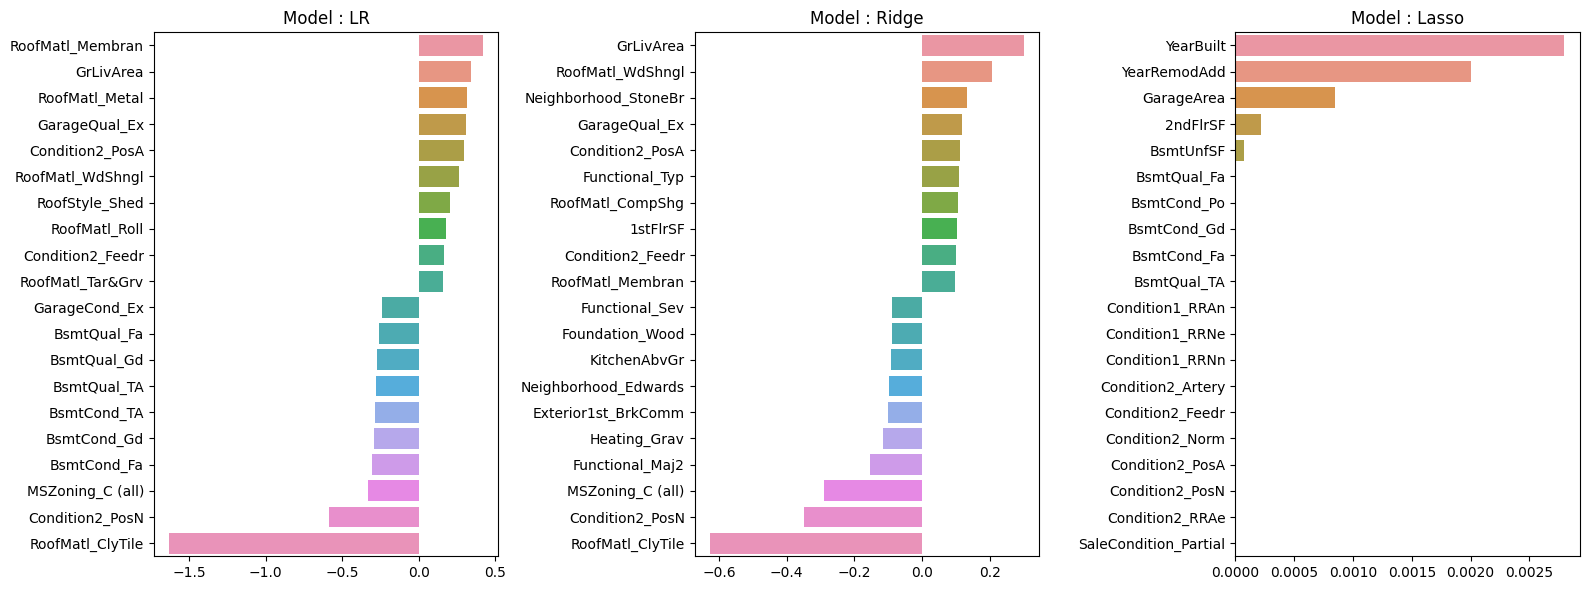

In [31]:
models_visualize(datas)

### (4) 이상치 데이터 처리

다음으로 좀 더 분석할 요소는 이상치 데이터  
특히 회귀 계수가 높은 피처들은  
예측에 많은 영향을 미치는 중요 피처들이기 때문에  
이들 피처들의 이상치 데이터 처리가 중요함  

먼저 3개 모델 모두에서 가장 큰 회귀 계수를 가지는  
GrLivArea(주거 공간 크기) 피처의 데이터 분포 살펴 볼 것임

In [32]:
# 이상치 데이터 검출을 위해 주요 피처인 GrLivArea(주거 공간 크기) 값에 대한 산포도 확인
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트에서
# GrLivArea(주거 공간 크기) 와 타깃 값인 SalePrice의 관계 시각화


Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

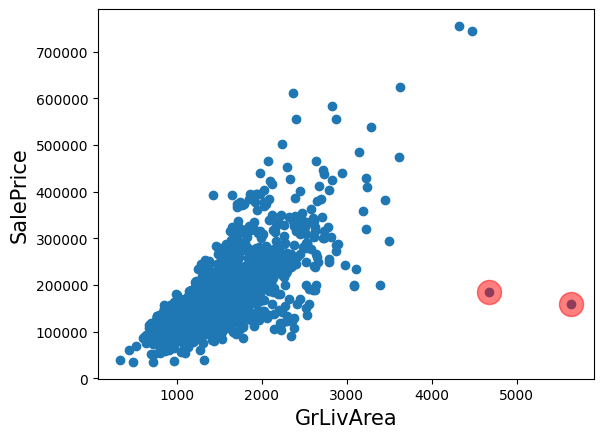

In [33]:
# 그래프에 확인한 이상치 표시
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)

outlier = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 200000)
outlier_df = house_df_org[outlier]
plt.scatter(x=outlier_df["GrLivArea"] , y=outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [34]:
need_to_drop = house_df_org[(house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 500000)].index
need_to_drop

Index([523, 1298], dtype='int64')

In [35]:
house_df_ohe2.drop(need_to_drop, inplace=True)

### (5) 릿지 / 라쏘 모델 최적화 수행 

In [36]:
X_feature = house_df_ohe2.drop('SalePrice', axis=1)
y_target = house_df_ohe2['SalePrice']
datas = data_sep(X_feature, y_target)

In [37]:
models_eval(datas)

<Linear Regression>
MSE : 0.015941
RMSE : 0.126256
R2 : 0.911418
---------------------
<Ridge>
MSE : 0.013058
RMSE : 0.114271
R2 : 0.927438
---------------------
<Lasso>
MSE : 0.064360
RMSE : 0.253693
R2 : 0.642354


### tip
- 일반적로 머신러닝 프로세스에서 데이터 전처리는 알고리즘 적용 전에 진행하지만    
- 처음부터 완벽하게 수행할 필요는 없음    
- 대략의 데이터 가공을 진행하고 모델 최적화를 진행한 후    
- 결과를 기반으로 다시 여러 가지 전처리 작업을 진행하는 것이 바람직함  

In [38]:
##################################################################

### 4. 회귀 트리 모델  : XGBoost와 LightGBM

선형 회귀
- 회귀 계수를 선형으로 결합하는 회귀 함수를 구해
- 여기에 독립변수를 입력해 결과값을 예측하는 것

비선형 회귀
- 비선형 회귀 함수를 통해 결과값을 예측

머신러닝 기반의 회귀
- 회귀 계수를 기반으로 하는 최적화 회구 함수를 도출하는 것이 목표

회귀 트리
- 회귀 함수를 기반으로 하지 않고
- 트리를 기반으로 하는 회귀 방식
- 분류 트리와 유사하지만
- 리프 노드에서 예측 결정값을 만든 과정에 차이가 있음
- 분류 트리 : 특정 클래스 레이블 결정
- 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산
    
CART(Classification And Regression Trees) 기반 알고리즘
- 결정트리, 랜덤 포레트스, GBM, XGBoost, LightGBM 등 트리 기반 알고리즘은
- 분류뿐만 아니라 회귀도 가능

### (1) 회귀 트리 모델 생성/학습/예측/평가   
- XGBoost와 LightGBM 이용해서 학습/예측/평가 수행

In [39]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
*_, X_train, X_test, y_train, y_test = datas

In [40]:
# XGBoost 회귀 트리 적용
xgb_params = {'n_estimators': [500, 1000]}
xgb_reg = XGBRegressor(object='reg:squarederror',
                      n_estimators=1000,
                      learning_rate=0.05,
                      colsample_bytree=0.5,
                      subsample=0.8)

xgb_reg.fit(X_train, y_train)
get_eval(xgb_reg, X_test, y_test)

# colsample_bytree=0.5
# - 각 트리(스텝)마다 사용할 피처 샘플링 비율 (0.5~1) (랜덤 샘플)
# - 일부만 샘플링해서 과적합 방지 

# subsample=0.8
# - 각 스텝마다 사용할 학습 데이터의 서브 샘플 비율
# 트리 성장 전 학습 데이터와 일부만 샘플링해서 과적합 방지 

# XGBRegressor 적용 시
# 5 폴드 세트 평균 RMSE : 0.1217
# 최종 릿지와 라쏘 모델보다 약간 성능이 낮게 나왔음

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, object='reg:squarederror', ...)

MSE : 0.014788
RMSE : 0.121604
R2 : 0.917826


In [41]:
# LightGBM 회귀 트리 적용
lgbm_params = {'n_estimators' :[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,
                        learning_rate=0.05,
                        num_leaves=4, # 하나의 트리가 가질 수 있는 최대 리프 수
                        colsample_bytree=0.5,
                        subsample=0.6,
                        reg_lambda=10, # L2 규제 적용 값,
                        force_row_wise=True)

lgbm_reg.fit(X_train, y_train)
get_eval(lgbm_reg, X_test, y_test)


# LGBMRegressor 회귀 트리 적용 시 
# 5 폴드 세트 평균 RMSE : 0.1166 (colsample_bytree=0.4)
# RMSE : 0.1170,(colsample_bytree=0.5)

# XGBRegressor 적용 시
# 5 폴드 세트 평균 RMSE : 0.1217

# LGBMRegressor가 XGBRegressor 보다 약간 수치 향상 있음

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 161
[LightGBM] [Info] Start training from score 12.030501


LGBMRegressor(colsample_bytree=0.5, force_row_wise=True, learning_rate=0.05,
              n_estimators=1000, num_leaves=4, reg_lambda=10, subsample=0.6)

MSE : 0.013568
RMSE : 0.116483
R2 : 0.924601


### (2) 피처 중요도 시각화  
- 트리 회귀 모델의 피처 중요도 시각화

In [42]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])



In [43]:
######################################################

### 5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
-   릿지 모델(40%)과 라쏘 모델(60%) 혼합 

개별 회귀 모델의 예측 결과값을 혼합해서  
이를 기반으로 최종 회귀 값 예측  

예측 결과 혼합 예  
A 모델 , B 모델  
A 모델의 예측값 40%, B 모델의 예측값의 60%를 더해서 최종 회귀값으로 예측  

A :[100, 80, 60]  , B : [120, 80, 50]  
[100*0.4 + 120*0.6, 80*0.4 + 80*0.6, 60*0.4 + 50*0.6]

In [44]:
from sklearn.metrics import mean_squared_error
def get_rmse_pred(preds, y_test):
    for key in preds.keys():
        y_pred = preds[key]
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print('RMSE of {0} model : {1:.6f}'.format(key, rmse))

In [60]:
ridge = Ridge(alpha=8)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

ratio = 0.4

comp_pred = ratio*ridge_pred + (1-ratio)*lasso_pred

preds = {'Ridge' : ridge_pred, 'Lasso' : lasso_pred, 'Composition' : comp_pred}
get_rmse_pred(preds, y_test)

Ridge(alpha=8)

Lasso(alpha=0.001)

RMSE of Ridge model : 0.110691
RMSE of Lasso model : 0.107668
RMSE of Composition model : 0.107695


In [46]:
######################################################################

### 6. 스태킹 앙상블 모델을 통한 회귀 예측 

스태킹 모델을 회귀에도 적용

스태킹(Stacking)
- 개별적인 여러 알고리즘을 서로 결합해서 예측 결과를 도출한다는 점에서는
- 배깅 및 부스팅 방식과 동일하지만
- 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로
- 다시 예측을 수행하는 것

(1) 개별 알고리즘의 예측 결과 데이터 세트를  
(2) 최종적인 메타 데이터 세트로 만들어  
(3) 별도의 ML 알고리즘으로 최종 학습을 수행하고  
(4) 테스트 데이터를 기반으로다시 최종 예측을 수행하는 방식  

메타 모델
- 개별 모델의 예측된 데이터 세트를 기반으로
- 다시 학습하고 예측하는 방식

스태킹 모델의 구현 방법 정리
- 두 종류의 모델 필요  
(1) 개별적인 기반 모델  
(2) 개별 기반 모델의 예측 데이터를 학습 데이터로 학습하는 최종 메타 모델  

스태킹 모델의 핵심
- 여러 개별 모델의 예측 데이터를  
- 각각 스태킹 형태로 결합해  
- 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것  

최종 메타 모델이 학습할 피처 데이터 세트  
- 원본 학습 피처 데이터 세트로 학습한 개별 모델의 예측값을  
- 스태킹 형태로 결합한 것  

In [47]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트용 데이터 세트를 생성하기 위한 함수
# 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서
# 원본 학습 데이터를 다시 추출해서 학습/예측 수행한 뒤 결과 저장
# --> 추후 메타 모델의 학습 피처 데이터 세트로 이용

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')   
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


In [54]:
# 4개의 모델에 대해 train, test 메타 데이터 생성
# 4개의 모델에 대해 train, test 메타 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 모델이 생성한 학습용/테스트용 데이터 반환 
ridge_train, ridge_test = get_stacking_base_datasets(ridge, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 816, number of used features: 148
[LightGBM] [Info] Start training from score 12.035489
	 폴드 세트:  1  시작 
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 816, number of used features: 149
[LightGBM] [Info] Start training from score 12.024132
	 폴드 세트:  2  시작 
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 816, number of used features: 148
[LightGBM] [Info] Start training from score 12.036231
	 폴드 세트:  3  시작 
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Nu

In [59]:
# 최종 메타 데이터 결합 
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  

Stack_final_X_train = np.concatenate([ridge_train, lasso_train, xgb_train, lgbm_train], axis=1)
Stack_final_X_test = np.concatenate([ridge_test, lasso_test, xgb_test, lgbm_test], axis=1)


# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.005)

# 기반 모델의 예측값을 기반으로 새롭게 만들어진
# 학습/테스트 데이터로 학습/예측하고 평가 RMSE 확인
meta_model_lasso.fit(Stack_final_X_train, y_train)
final_y_pred = meta_model_lasso.predict(Stack_final_X_test)

# 평가
mse = mean_squared_error(y_test, final_y_pred)
rmse = np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE : %.6f'%rmse)

Lasso(alpha=0.005)

스태킹 회귀 모델의 최종 RMSE : 0.108940
